In [457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import r2_score

from scipy import stats

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

import pyprind

In [550]:
properties = pd.read_csv('data/sales_data_2015.csv', index_col=0, low_memory=False)
sat_data = pd.read_csv('data/sales_data_2015_DF-inception-conv.csv', index_col=0, low_memory=False)
print(properties.shape)

(84768, 26)


In [551]:
# Satelite Dataset
print(sat_data.shape)
print("Unique bbl_ids:", len(sat_data['bbl_id'].unique()))
print("Unique sale_ids:", len(sat_data['Sale_id'].unique()))

(84302, 34)
Unique bbl_ids: 62872
Unique sale_ids: 84302


# Joining

In [552]:
sat_prop = properties.join(sat_data, on='Sale_id', how='inner', lsuffix='_prop', rsuffix='_sat')

In [553]:
#Dropping rows with price, sqft and year = 0
print("Before:", len(sat_prop))
sat_prop = sat_prop[(sat_prop.yr_built != 0) & (sat_prop.tot_sqft != 0) & (sat_prop.price != 0)]
print("After:", len(sat_prop))

Before: 84301
After: 28401


# Preprocessing

In [554]:
#Dropping rows with price less than 10k, indiciates some family transfers and not everly useful in general
print("Before", len(sat_prop[(sat_prop['price'] < 10000)]))
sat_prop = sat_prop[sat_prop.price > 10000]
print("After", len(sat_prop[(sat_prop['price'] < 10000)]))

print("Minimum price:", sat_prop['price'].min())
print("Maximum price:", sat_prop['price'].max())

Before 813
After 0
Minimum price: 10667
Maximum price: 555000000


In [555]:
sat_prop.isna().sum().sort_values(ascending=False)

easmnt         27559
apt            27123
31                 0
com_unit           0
Sale_id_sat        0
               ...  
6                  0
5                  0
4                  0
3                  0
Sale_id            0
Length: 61, dtype: int64

In [556]:
#Dropping nan columns
sat_prop = sat_prop.drop(['easmnt', 'apt'], axis=1)

In [557]:
#Dropping id columns, year, zip, lon lat coordinates, lot id
sat_prop = sat_prop.drop(['usable','sale_date', 'address', 'bbl_id_prop', 
                      'Sale_id', 'year', 'lot', 'Sale_id_prop', 'res_unit', 'com_unit',
                      'bbl_id_sat', 'bbl_id_sat', 'Sale_id_sat', 'lat', 'long'], axis=1)

In [559]:
# sat_prop.info()

## Hot encoding

In [561]:
X_enc = sat_prop.copy()
X_enc = pd.get_dummies(X_enc, columns=['bldg_ctgy','tax_cls_s','tax_cls_p','bldg_cls_p', 'bldg_cls_s'])
sat_prop = X_enc

print(sat_prop.shape)

(27559, 351)


## Label encoding ?

In [519]:
# encoder = LabelEncoder()
# bldg_ctgy_enc = encoder.fit_transform(sat_prop['bldg_ctgy'].values)
# tax_cls_p_enc = encoder.fit_transform(sat_prop['tax_cls_p'].values)
# bldg_cls_p_enc = encoder.fit_transform(sat_prop['bldg_cls_p'].values)
# bldg_cls_s_enc = encoder.fit_transform(sat_prop['bldg_cls_s'].values)

In [520]:
# sat_prop['bldg_ctgy'] = bldg_ctgy_enc
# sat_prop['tax_cls_p'] = tax_cls_p_enc
# sat_prop['bldg_cls_p'] = bldg_cls_p_enc
# sat_prop['bldg_cls_s'] = bldg_cls_s_enc

In [521]:
# len(sat_prop['bldg_cls_s'].unique())

## Outlier detection for prices

In [562]:
z_score_price = np.abs(stats.zscore(sat_prop['price']))
sat_prop['z_score_price'] = z_score_price

z_score_tot_sqft = np.abs(stats.zscore(sat_prop['tot_sqft']))
sat_prop['z_score_tot_sqft'] = z_score_tot_sqft

# z_score_yr_built = np.abs(stats.zscore(sat_prop['yr_built']))
# sat_prop['z_score_yr_built'] = z_score_yr_built

print("Before shape:", sat_prop.shape)

sat_prop = sat_prop[(sat_prop.z_score_price < 3) & (sat_prop.z_score_tot_sqft < 3)]
sat_prop = sat_prop.drop(['z_score_tot_sqft', 'z_score_price'], axis=1)

print("After shape:", sat_prop.shape)

Before shape: (27559, 353)
After shape: (27339, 351)


# EDA

In [564]:
sat_prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27339 entries, 4 to 84297
Columns: 351 entries, borough to bldg_cls_s_Z9
dtypes: float64(32), int64(8), uint8(311)
memory usage: 16.7 MB


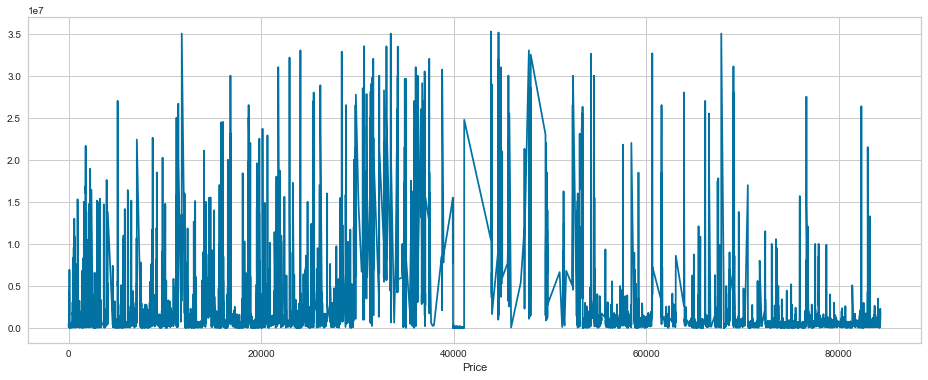

In [523]:
# Prices dist
prices = sat_prop['price']
plt.figure(figsize=(16,6))
plt.xlabel("Price")
plt.plot(prices)

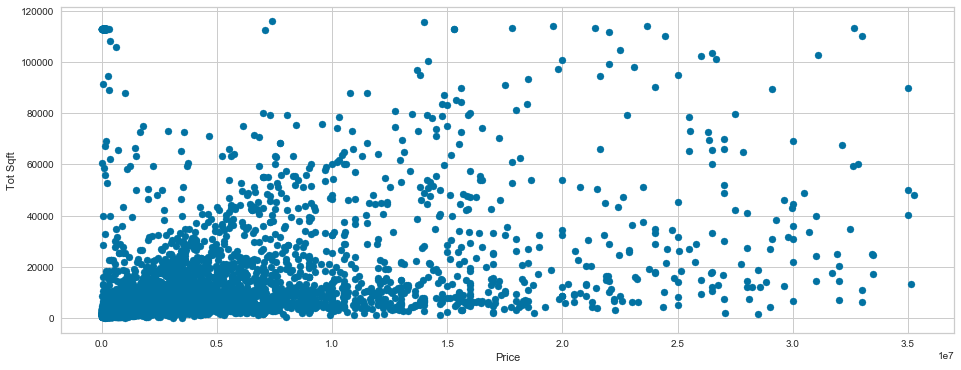

In [524]:
plt.figure(figsize=(16,6))
plt.xlabel("Price")
plt.ylabel("Tot Sqft")
plt.scatter(sat_prop['price'], sat_prop['tot_sqft'])

## Export proccessed data

In [525]:
# sat_prop.to_csv("out/processed_data.csv")

# Analysis

In [526]:
property_prices = sat_prop['price']
print(property_prices.shape)

(27339,)


In [527]:
property_data = sat_prop.drop(['price'], axis=1)
print(property_data.shape)

(27339, 350)


In [528]:
X_train, X_test, y_train, y_test = train_test_split(property_data, property_prices, test_size=0.1, random_state = 42)

## Linear Reg.

In [569]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# R^2 scores
print('Train:', lr.score(X_train, y_train))
print('Test:', lr.score(X_test, y_test))

Train: 0.5360790334712586
Test: 0.5004195120838903


## Lasso Regression

In [565]:
lasso = Lasso(alpha=20)
lasso.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

print("Test score:",r2_score(y_test, y_pred))

Test score: 0.4997127211600676


/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.59308730441676e+16, tolerance: 19717638861024.52
  positive)


In [568]:
scores = cross_val_score(estimator=lasso, X=X_train, y=y_train, cv=10, n_jobs=1)
print("Scores", scores)
print("Mean Score:", np.mean(scores))

/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6861594980101304e+16, tolerance: 17438519125601.326
  positive)
/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.149457213414161e+16, tolerance: 17866611562700.773
  positive)
/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.081486831053969e+16, tolerance: 17549401591628.91
  positive)
/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not conve

Scores [0.50633902 0.46567312 0.50143397 0.53910121 0.44862662 0.44113667
 0.41494517 0.44086648 0.51426081 0.49000842]
Mean Score: 0.4762391481611098


/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.242434563824306e+16, tolerance: 18288385232947.01
  positive)


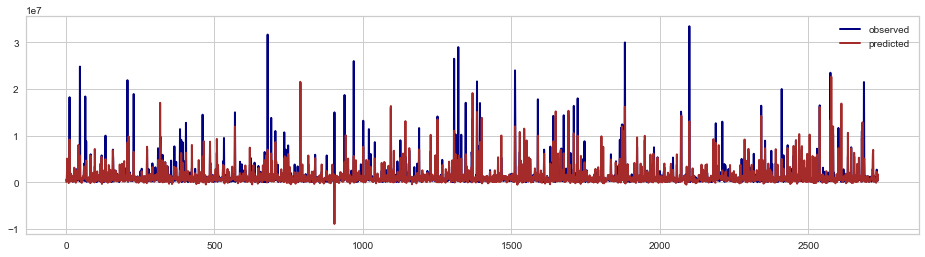

In [530]:
lasso_obs_pred=pd.DataFrame({'entry': range(1,len(y_test)+1), 'observed': y_test, 'predicted': y_pred})
plt.figure(figsize=(16,4))
plt.plot('entry', 'observed', data=lasso_obs_pred, marker='', color='navy', linewidth=2)
plt.plot('entry', 'predicted', data=lasso_obs_pred, marker='', color='brown', linewidth=2)
plt.legend()

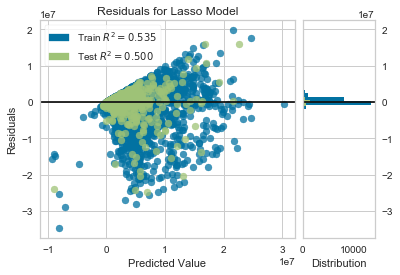

In [531]:
visualizer = ResidualsPlot(lasso_model, hist=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Gradient Boost

In [538]:
gb_2 = GradientBoostingRegressor(n_estimators=200,max_depth=12, verbose=True)
gb_2.fit(X_train, y_train)
gb_2_predicted = gb_2.predict(X_test)

print('Score on training', gb_2.score(X_train, y_train))
print("Score on test:", r2_score(y_test, rf_2_predicted))

      Iter       Train Loss   Remaining Time 
         1 6629966167290.5703            6.42m
         2 5499368913396.4902            6.53m
         3 4568745893173.9268            6.47m
         4 3820124878306.9116            6.49m
         5 3181691730431.5303            6.47m
         6 2664480021753.6650            6.53m
         7 2231001718060.2661            6.52m
         8 1882105025074.4172            6.49m
         9 1595769868504.1606            6.49m
        10 1351863930230.6780            6.44m
        20 329588073289.2286            6.07m
        30 135348551592.0534            5.57m
        40 82896743728.5427            5.14m
        50 64831114207.5887            4.68m
        60 55761609261.4301            4.18m
        70 51053624581.8658            3.72m
        80 46816906253.3220            3.33m
        90 43903672581.3123            2.94m
       100 41310086146.2563            2.60m
       200 28260944444.6108            0.00s
Score on training 0.996473408692

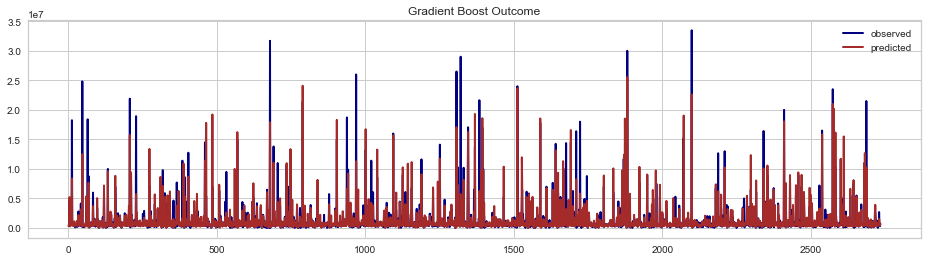

In [539]:
gb_obs_pred=pd.DataFrame({'entry': range(1,len(y_test)+1), 'observed': y_test, 'predicted': gb_2_predicted})
plt.figure(figsize=(16,4))
plt.title("Gradient Boost Outcome")
plt.plot('entry', 'observed', data=gb_obs_pred, marker='', color='navy', linewidth=2)
plt.plot('entry', 'predicted', data=gb_obs_pred, marker='', color='brown', linewidth=2)
plt.legend()

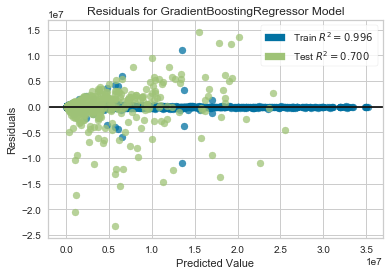

In [540]:
visualizer = ResidualsPlot(gb_2, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

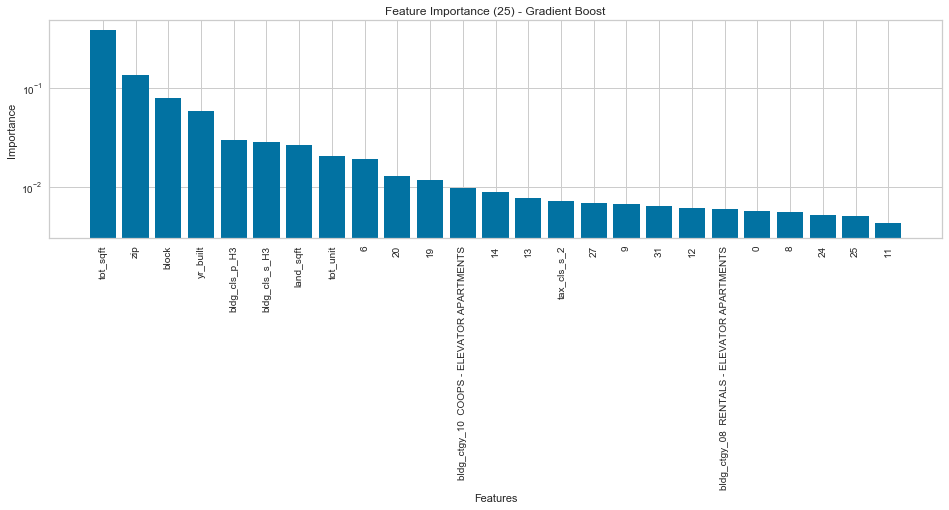

In [548]:
treshold = 25

df_feature_importance = pd.DataFrame()
df_feature_importance['features'] = list(property_data)
df_feature_importance['importance'] = gb_2.feature_importances_

df_feature_importance = df_feature_importance.sort_values('importance').tail(treshold)

plt.figure(figsize=(16,4))
plt.yscale('log',nonposy='clip')
plt.bar(range(treshold),df_feature_importance['importance'][:treshold].values[::-1],align='center')

plt.xticks(range(treshold),df_feature_importance['features'][:treshold].values[::-1],rotation='vertical')
plt.title('Feature Importance (25) - Gradient Boost')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

## Tree Regressors

In [541]:
rf_2 = RandomForestRegressor(n_estimators=200,criterion='mse',max_depth=20,random_state=42, verbose=True)
rf_2.fit(X_train, y_train)
rf_2_predicted = rf_2.predict(X_test)

print("Train score:", rf_2.score(X_train, y_train))
print("Test score:", r2_score(y_test, rf_2_predicted))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train score: 0.9528051711571689
Test score: 0.7306980143876152


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


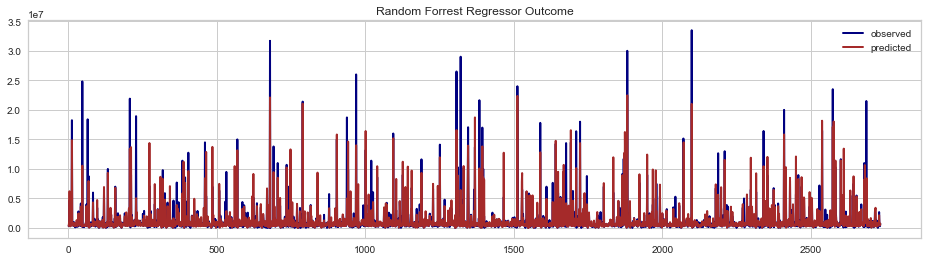

In [542]:
rf_obs_pred=pd.DataFrame({'entry': range(1,len(y_test)+1), 'observed': y_test, 'predicted': rf_2_predicted})
plt.figure(figsize=(16,4))
plt.title("Random Forrest Regressor Outcome")
plt.plot('entry', 'observed', data=rf_obs_pred, marker='', color='navy', linewidth=2)
plt.plot('entry', 'predicted', data=rf_obs_pred, marker='', color='brown', linewidth=2)
plt.legend()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


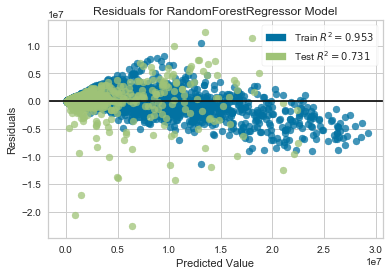

In [543]:
visualizer = ResidualsPlot(rf_2, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

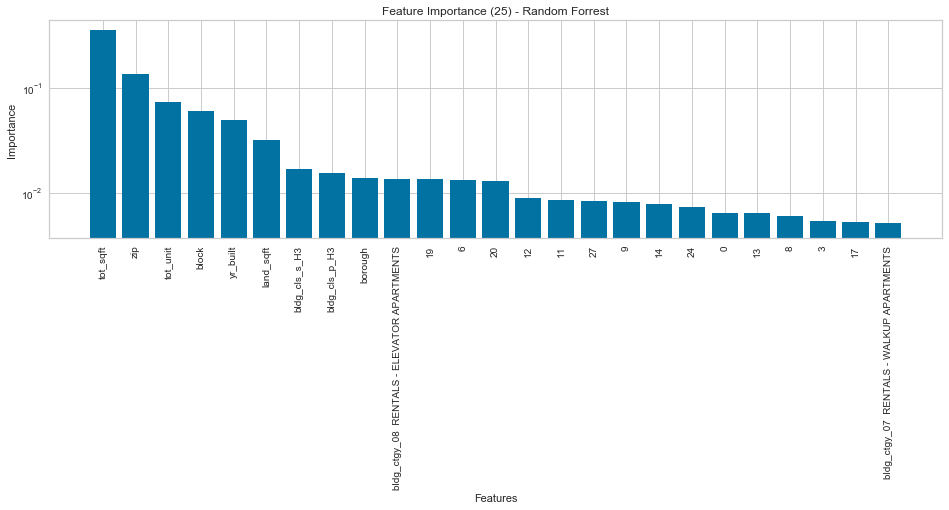

In [549]:
treshold = 25

df_feature_importance = pd.DataFrame()
df_feature_importance['features'] = list(property_data)
df_feature_importance['importance'] = rf_2.feature_importances_

df_feature_importance = df_feature_importance.sort_values('importance').tail(treshold)

plt.figure(figsize=(16,4))
plt.yscale('log',nonposy='clip')
plt.bar(range(treshold),df_feature_importance['importance'][:treshold].values[::-1],align='center')

plt.xticks(range(treshold),df_feature_importance['features'][:treshold].values[::-1],rotation='vertical')
plt.title('Feature Importance (25) - Random Forrest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()